In [1]:
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import utils as ut
import matplotlib.pyplot as plt

In [2]:
import sys
import os
from PIL import Image

notebook_dir = os.path.dirname(os.path.abspath("__file__"))

test_images_path = os.path.abspath(os.path.join(notebook_dir, '../../../test_images'))



In [3]:
low_detail_img_path = os.path.join(test_images_path, 'palm.bmp')
low_detail_img = Image.open(low_detail_img_path)
if low_detail_img.mode != 'L':  # 'L' gri tonlamayı temsil eder
    low_detail_img = low_detail_img.convert('L')

high_detail_img_path = os.path.join(test_images_path, 'fbtaraftar.bmp')
high_detail_img = Image.open(high_detail_img_path)
if high_detail_img.mode != 'L':
    high_detail_img = high_detail_img.convert('L')


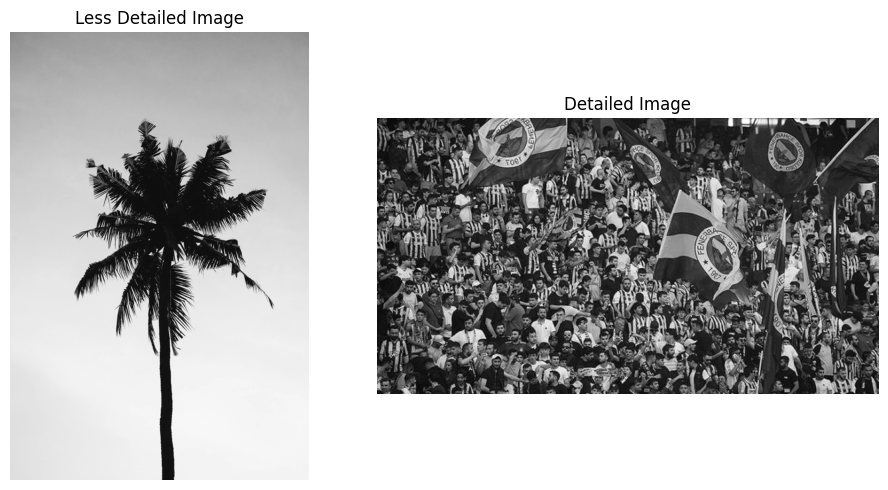

In [4]:
ut.image_plotter([low_detail_img, high_detail_img], ['Less Detailed Image', 'Detailed Image'])

In [5]:
def calculate_pixel_value_frequencies(image):
    image_array = np.array(image)
    pixel_frequency_dict = {}
    
    for row in range(image_array.shape[0]):
        for col in range(image_array.shape[1]):
            pixel_value = image_array[row][col]
            if pixel_value in pixel_frequency_dict:
                pixel_frequency_dict[pixel_value] += 1
            else:
                pixel_frequency_dict[pixel_value] = 1

    sorted_pixel_frequencies = dict(sorted(pixel_frequency_dict.items()))
    return sorted_pixel_frequencies

def plot_pixel_value_histogram(pixel_frequency_dict, title, y_label = "Frequency", x_label="Pixel Value", subtitle=None, image=None, ax=None, percentage=False):
    if ax is None:
        ax = plt.gca()

    pixel_values = list(pixel_frequency_dict.keys())
    frequency_counts = list(pixel_frequency_dict.values())

    total_pixels = sum(frequency_counts)

    y_values = frequency_counts
    if percentage:
        y_values = [(count / total_pixels) * 100 for count in frequency_counts]
        y_label = f'{y_label} Percentage (%)'

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.bar(pixel_values, y_values)
    ax.set_title(title)
    if subtitle is not None:
        ax.set_title(title + '\n' + subtitle)

    if image is not None:
        inset_ax = ax.inset_axes([0.7, 0.7, 0.25, 0.25])  # Pozisyon ve boyut ayarı
        inset_ax.imshow(image, cmap='gray')
        inset_ax.axis('off')  # Eksenleri kapat

    return ax

def plot_image(image, title, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

    return ax

def calculate_entropy(pixel_freq):
    total_pixels = sum(pixel_freq.values())
    entropy = 0
    for freq in pixel_freq.values():
        prob = freq / total_pixels
        entropy += -prob * np.log2(prob)
    return entropy

def compute_pmf(pixel_freq):
    total_pixels = sum(pixel_freq.values())
    pmf = {pixel: freq / total_pixels for pixel, freq in pixel_freq.items()}
    return pmf

from PIL import Image, ImageOps

def create_3d_crop_overlay(image, crop_box, offset=(10, 20), zoom_factor=0.1, position='bottom-left', background_scale=0.5):
    # Şeffaf bir arka plan oluştur
    result_image = Image.new("RGBA", image.size, (255, 255, 255, 0))

    # Orta katman: Küçültülmüş orijinal görüntü
    background = image.resize(
        (int(image.width * background_scale), int(image.height * background_scale))
    )
    # Küçültülmüş orijinal görüntüyü sağ üst köşeye yerleştir
    bg_x = image.width - background.width
    bg_y = 0
    result_image.paste(background, (bg_x, bg_y))

    # Ön katman: Büyütülmüş kırpma alanı ve kenarlık
    cropped_region = image.crop(crop_box)
    zoomed_region = cropped_region.resize(
        (int(cropped_region.width * zoom_factor), int(cropped_region.height * zoom_factor))
    )
    zoomed_region_with_border = ImageOps.expand(zoomed_region, border=5, fill='blue')

    # Ön kutunun konumunu belirle
    if position == 'bottom-right':
        crop_x = image.width - zoomed_region_with_border.width - offset[0]
        crop_y = image.height - zoomed_region_with_border.height - offset[1]
    elif position == 'top-right':
        crop_x = image.width - zoomed_region_with_border.width - offset[0]
        crop_y = offset[1]
    elif position == 'bottom-left':
        crop_x = offset[0]
        crop_y = image.height - zoomed_region_with_border.height - offset[1]
    elif position == 'top-left':
        crop_x = offset[0]
        crop_y = offset[1]
    else:
        raise ValueError("Position should be 'bottom-right', 'top-right', 'bottom-left', or 'top-left'")

    # Büyütülmüş kırpılmış alanı belirlenen konuma yapıştır, mask parametresini kullanmıyoruz
    result_image.paste(zoomed_region_with_border, (int(crop_x), int(crop_y)))

    return result_image


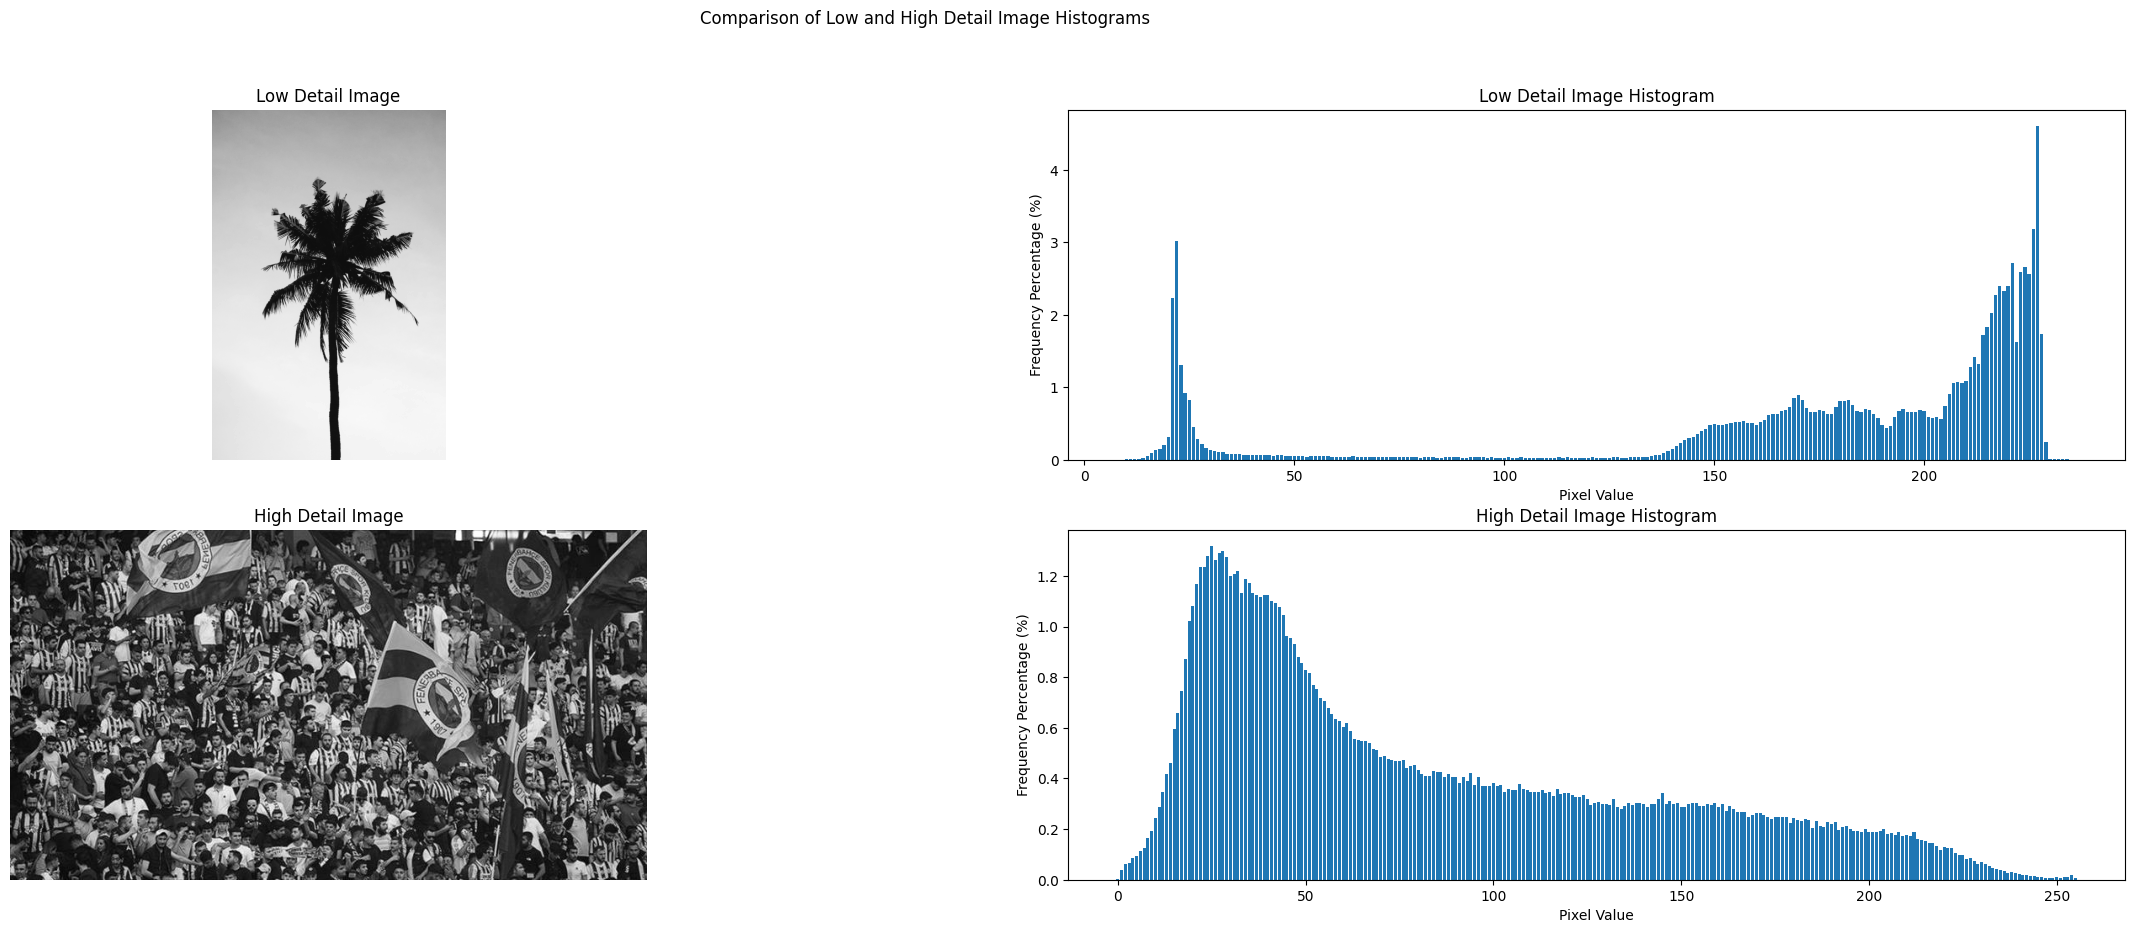

In [6]:
low_detail_freq = calculate_pixel_value_frequencies(low_detail_img)
high_detail_freq = calculate_pixel_value_frequencies(high_detail_img)



fig, axes = plt.subplots(2, 2, figsize=(30, 10))

ax_low_image, ax_low = axes[0]
ax_high_image, ax_high = axes[1]

# Histogramları alt eksenlerde çizme
plot_pixel_value_histogram(low_detail_freq, 'Low Detail Image Histogram', ax=ax_low, percentage=True)
plot_pixel_value_histogram(high_detail_freq, 'High Detail Image Histogram', ax=ax_high, percentage=True)

# Görüntüleri alt eksenlerde gösterme

plot_image(low_detail_img, 'Low Detail Image', ax=ax_low_image)
plot_image(high_detail_img, 'High Detail Image', ax=ax_high_image)


# Genel başlık ve gösterim
fig.suptitle('Comparison of Low and High Detail Image Histograms')
plt.show()


Low Detail Image Entropy: 6.600010033090847
High Detail Image Entropy: 7.5453554144295705


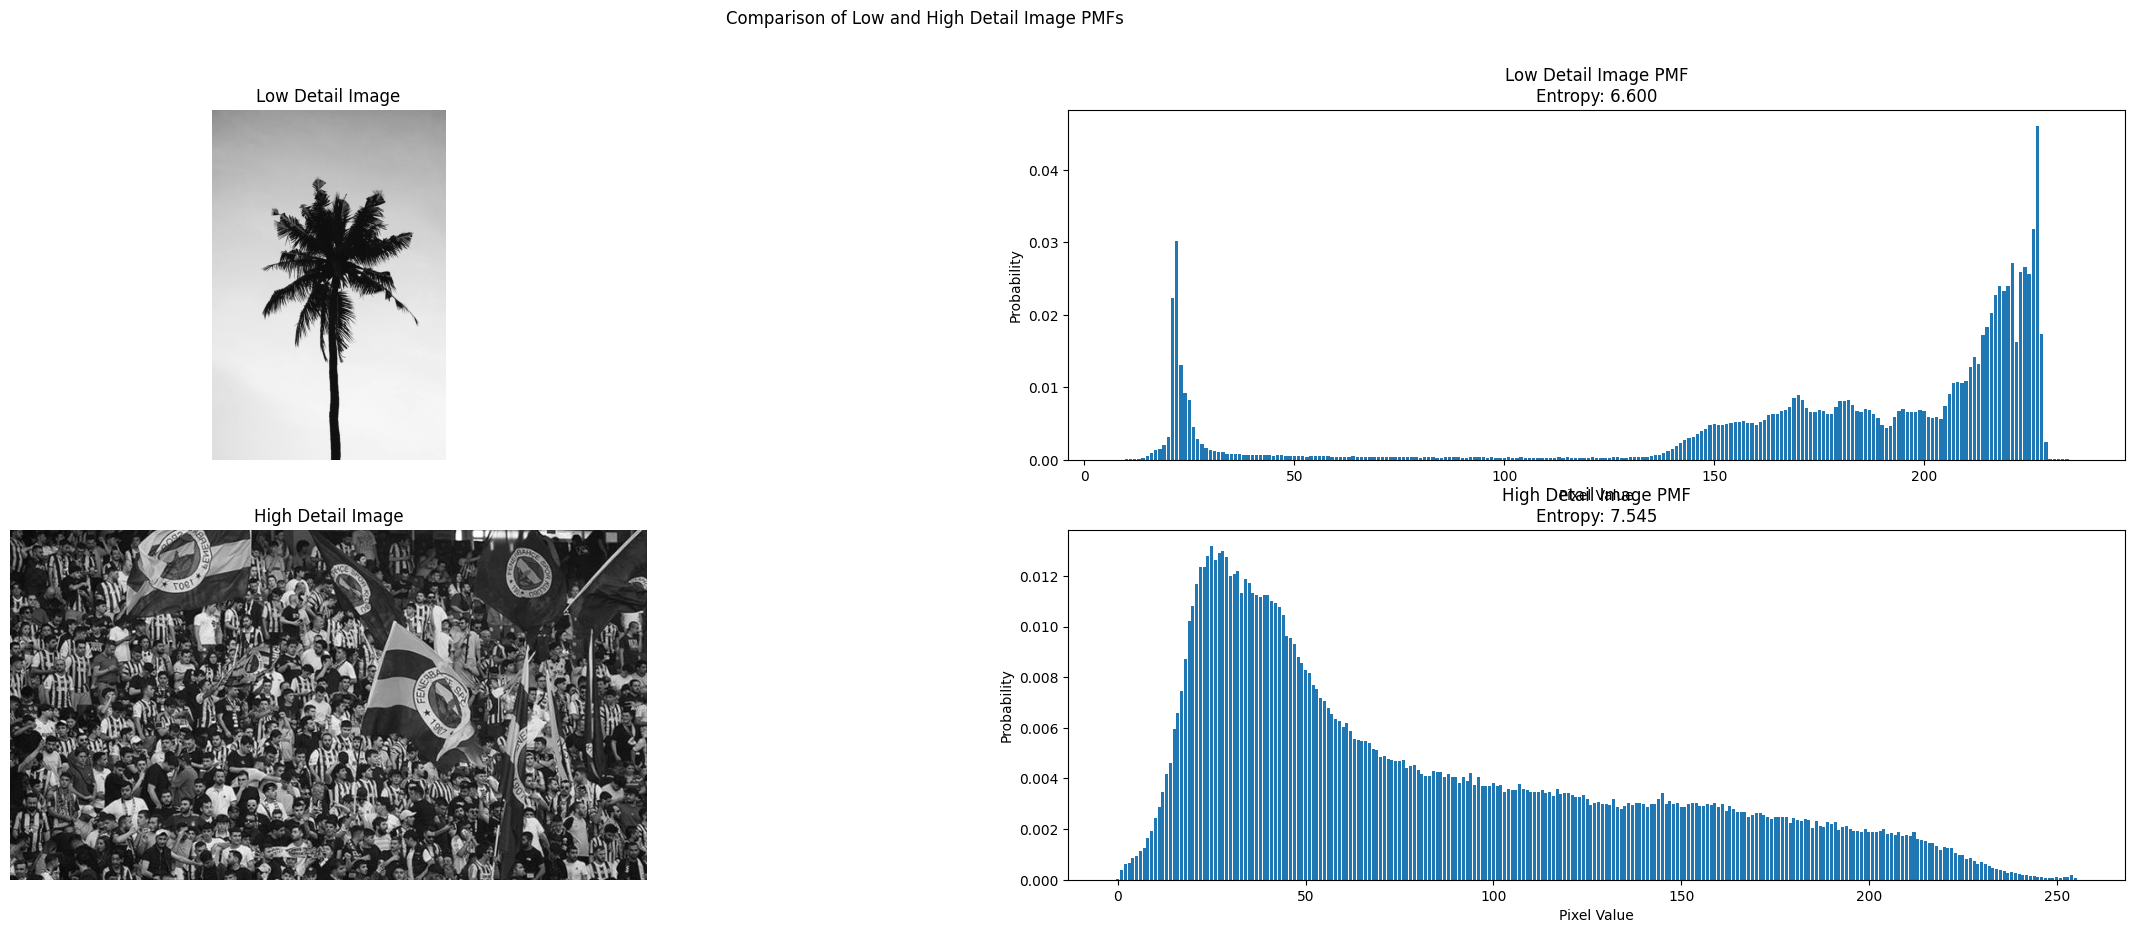

In [7]:
low_detail_entropy = calculate_entropy(low_detail_freq)
high_detail_entropy = calculate_entropy(high_detail_freq)

print(f'Low Detail Image Entropy: {low_detail_entropy}')
print(f'High Detail Image Entropy: {high_detail_entropy}')

low_detail_pmf = compute_pmf(low_detail_freq)
high_detail_pmf = compute_pmf(high_detail_freq)

fig, axes = plt.subplots(2, 2, figsize=(30, 10))

ax_low_image, ax_low = axes[0]
ax_high_image, ax_high = axes[1]

plot_pixel_value_histogram(low_detail_pmf, 'Low Detail Image PMF', y_label="Probability", subtitle=f"Entropy: {low_detail_entropy:.3f}", ax=ax_low)
plot_pixel_value_histogram(high_detail_pmf, 'High Detail Image PMF', y_label="Probability",subtitle=f"Entropy: {high_detail_entropy:.3f}", ax=ax_high)



plot_image(low_detail_img, 'Low Detail Image', ax=ax_low_image)
plot_image(high_detail_img, 'High Detail Image', ax=ax_high_image)


fig.suptitle('Comparison of Low and High Detail Image PMFs')
plt.show()

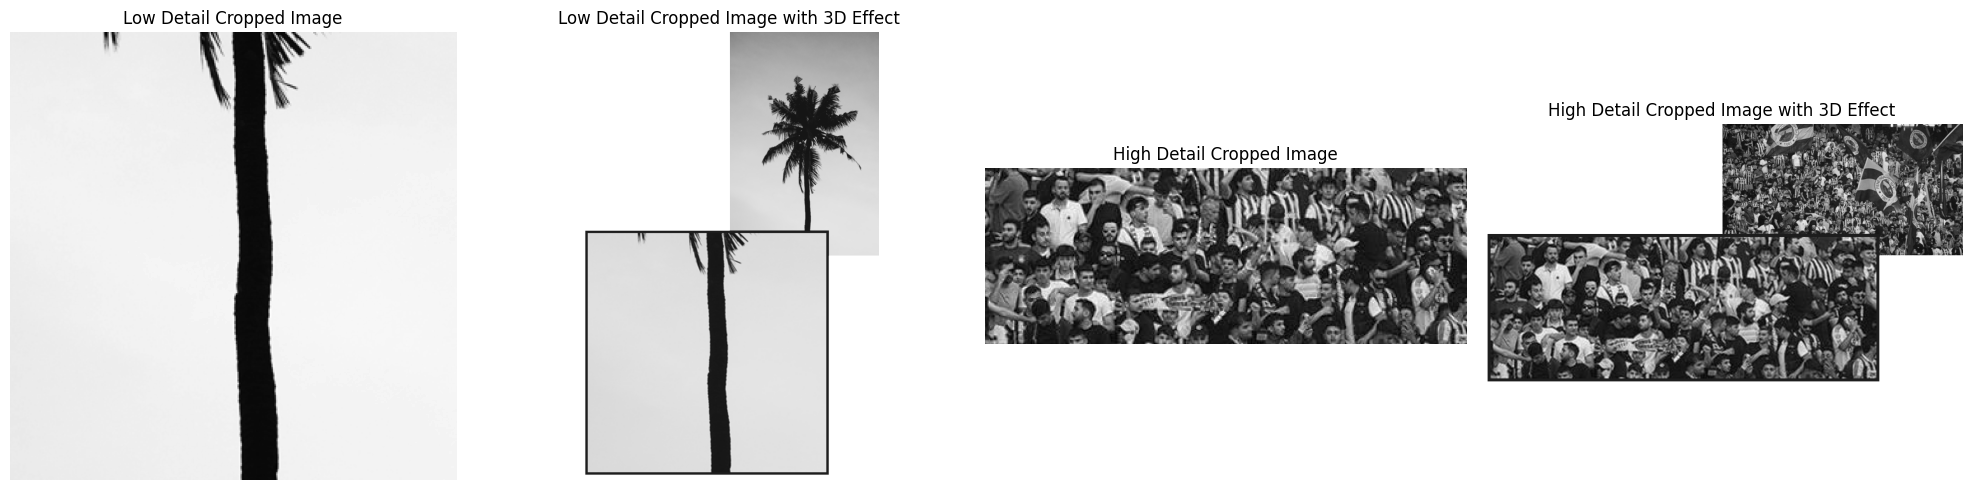

In [8]:
low_detailed_crop_box = (
    low_detail_img.width / 4, 
    low_detail_img.height / 1.5, 
    3 * low_detail_img.width / 4, 
    low_detail_img.height
    )

high_detailed_crop_box = (
    high_detail_img.width / 4, 
    high_detail_img.height / 1.5, 
    3 * high_detail_img.width / 4, 
    high_detail_img.height
    )

low_detail_cropped_image = low_detail_img.crop(low_detailed_crop_box)
high_detail_cropped_image = high_detail_img.crop(high_detailed_crop_box)

low_detail_cropped_image_with_effect = create_3d_crop_overlay(low_detail_img, low_detailed_crop_box, offset=(10, 10), zoom_factor=1.6)
high_detail_cropped_image_with_effect = create_3d_crop_overlay(high_detail_img, high_detailed_crop_box, offset=(10, 10), zoom_factor=1.6)


ut.image_plotter(
    [low_detail_cropped_image, low_detail_cropped_image_with_effect, high_detail_cropped_image, high_detail_cropped_image_with_effect],
    ['Low Detail Cropped Image', 'Low Detail Cropped Image with 3D Effect', 'High Detail Cropped Image', 'High Detail Cropped Image with 3D Effect']
)



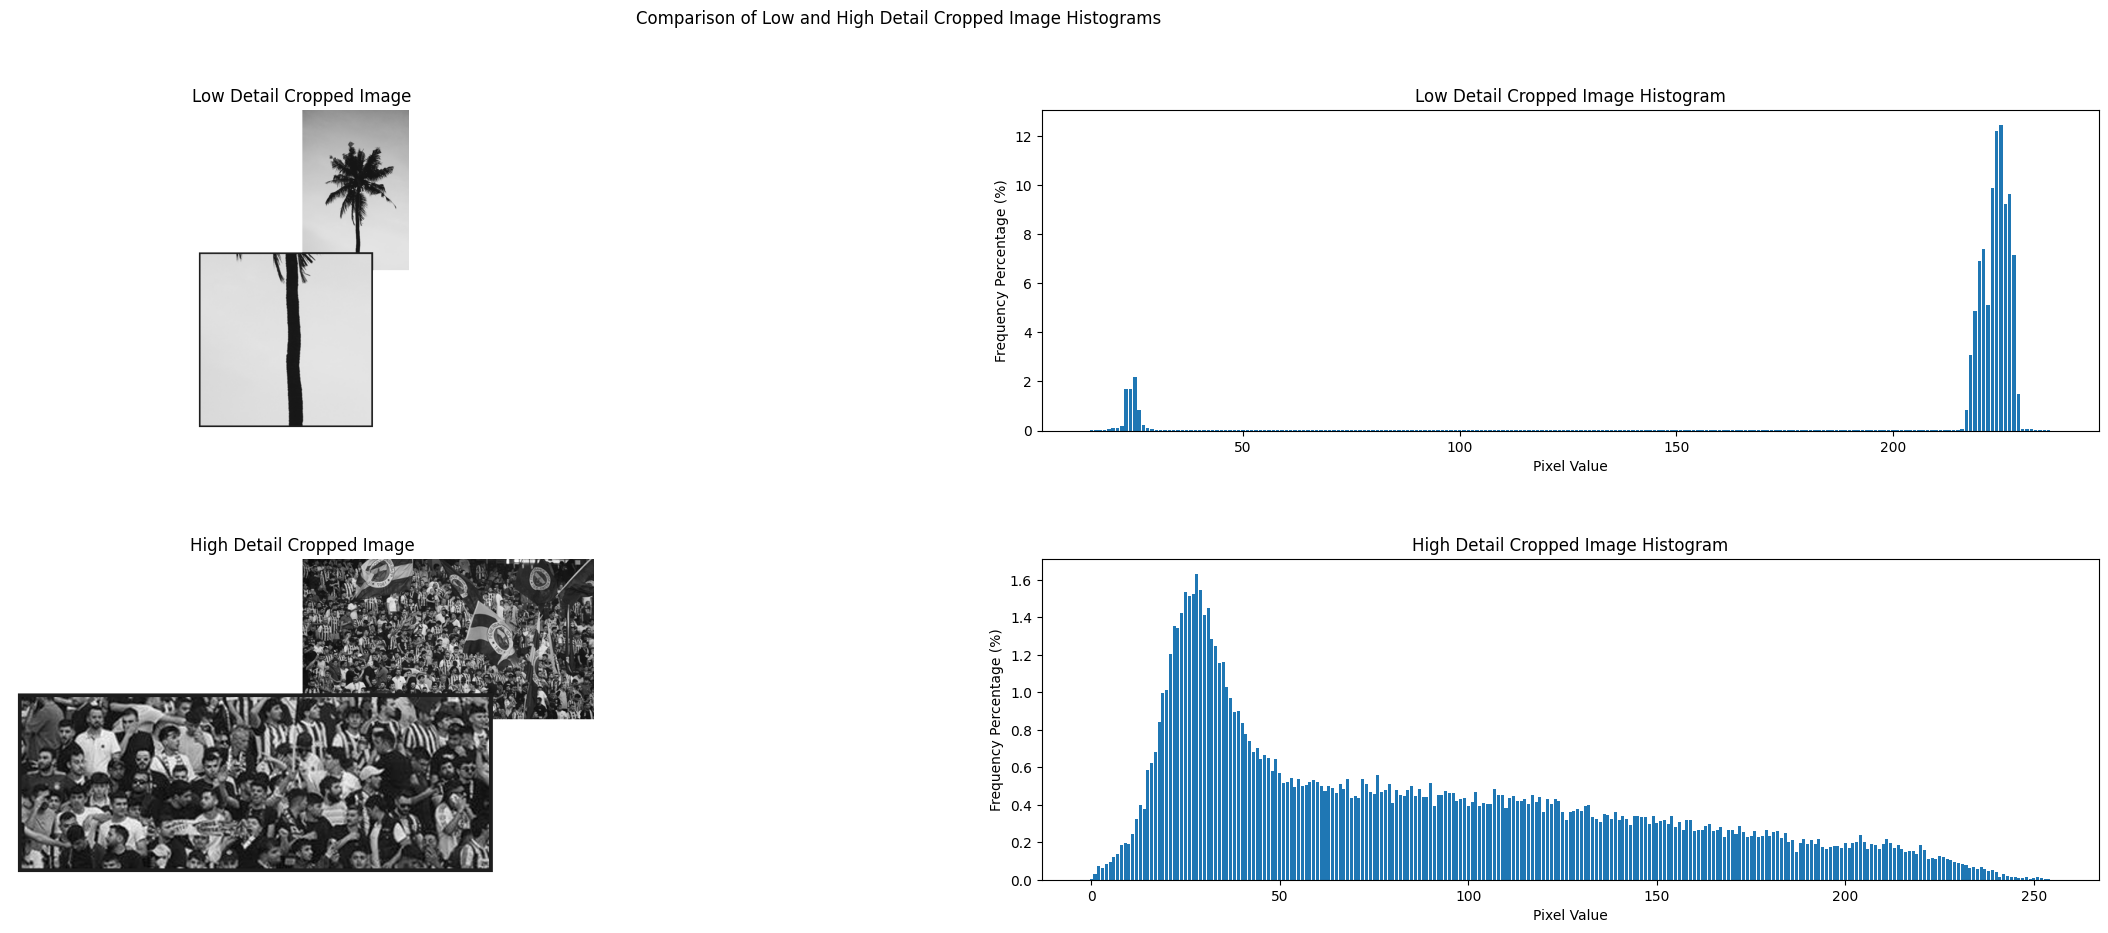

In [9]:
low_detail_cropped_freq = calculate_pixel_value_frequencies(low_detail_cropped_image)
high_detail_cropped_freq = calculate_pixel_value_frequencies(high_detail_cropped_image)

fig, axes = plt.subplots(2, 2, figsize=(30, 10))
fig.subplots_adjust(hspace=0.4) 

ax_low_image, ax_low = axes[0]
ax_high_image, ax_high = axes[1]

plot_pixel_value_histogram(low_detail_cropped_freq, 'Low Detail Cropped Image Histogram', percentage=True, ax=ax_low)
plot_pixel_value_histogram(high_detail_cropped_freq, 'High Detail Cropped Image Histogram', percentage=True, ax=ax_high)


ax_low_image.imshow(low_detail_cropped_image_with_effect, cmap='gray')
ax_low_image.axis('off')
ax_low_image.set_title('Low Detail Cropped Image')

ax_high_image.imshow(high_detail_cropped_image_with_effect, cmap='gray')
ax_high_image.axis('off')
ax_high_image.set_title('High Detail Cropped Image')


fig.suptitle('Comparison of Low and High Detail Cropped Image Histograms')
plt.show()

Low Detail Cropped Image Entropy: 4.050224559918251
High Detail Cropped Image Entropy: 7.578062912499827


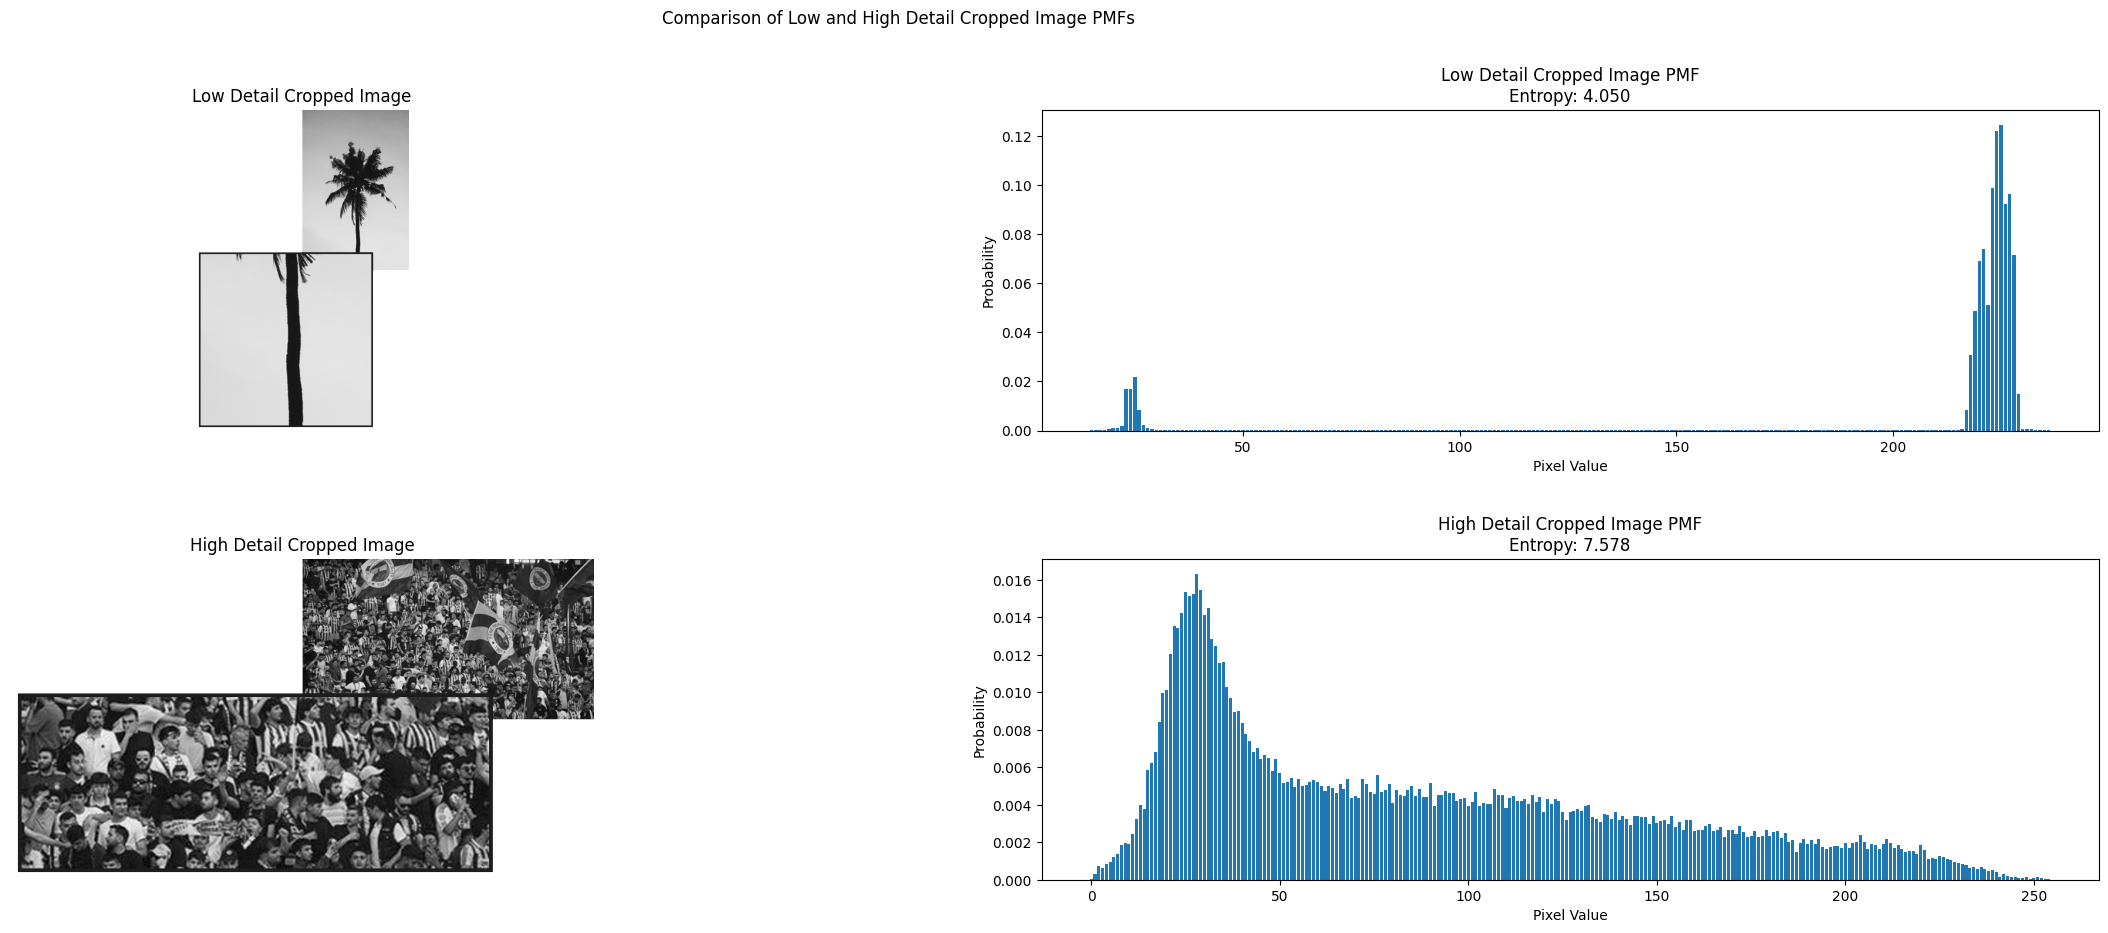

In [10]:
low_detai_cropped_entropy = calculate_entropy(low_detail_cropped_freq)
high_detail_cropped_entropy = calculate_entropy(high_detail_cropped_freq)

print(f'Low Detail Cropped Image Entropy: {low_detai_cropped_entropy}')
print(f'High Detail Cropped Image Entropy: {high_detail_cropped_entropy}')

low_detail_cropped_pmf = compute_pmf(low_detail_cropped_freq)
high_detail_cropped_pmf = compute_pmf(high_detail_cropped_freq)

fig, axes = plt.subplots(2, 2, figsize=(30, 10))
fig.subplots_adjust(hspace=0.4) 

ax_low_image, ax_low = axes[0]
ax_high_image, ax_high = axes[1]

plot_pixel_value_histogram(low_detail_cropped_pmf, 'Low Detail Cropped Image PMF', y_label="Probability", subtitle=f"Entropy: {low_detai_cropped_entropy:.3f}", ax=ax_low)
plot_pixel_value_histogram(high_detail_cropped_pmf, 'High Detail Cropped Image PMF', y_label="Probability", subtitle=f"Entropy: {high_detail_cropped_entropy:.3f}", ax=ax_high)


plot_image(low_detail_cropped_image_with_effect, 'Low Detail Cropped Image', ax=ax_low_image)
plot_image(high_detail_cropped_image_with_effect, 'High Detail Cropped Image', ax=ax_high_image)

fig.suptitle('Comparison of Low and High Detail Cropped Image PMFs')
plt.show()
